In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
base_metadata_pth = Path('/home/tsakalis/ntua/nestor_celvia/metadata')

basic_metadata_file = 'metadata.repository.2024-11-05.json'
clinical_cohort_file = 'clinical.cohort.2024-11-07.json'
biospecimen_file = 'biospecimen.cohort.2024-11-07.json'
gene_expr_file = 'Human__TCGA_OV__UNC__RNAseq__GA_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct'
# gene_expr_file = "Human__TCGA_OV__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct"

gene_mutation_file = 'Human__TCGA_OV__WUSM__Mutation__GAIIx__01_28_2016__BI__Gene__Firehose_MutSig2CV.cbt'

In [4]:
gene_names = pd.read_csv(base_metadata_pth / 'GeneNames.tsv', header=None)

In [5]:
metadata_df = pd.read_json(base_metadata_pth / basic_metadata_file)

clinical_cohort_df = pd.read_json(base_metadata_pth / clinical_cohort_file)

biospecimen_df = pd.read_json(base_metadata_pth / biospecimen_file)
gene_expr_df = pd.read_csv(base_metadata_pth / gene_expr_file, delimiter='\t')

gene_mutation_df = pd.read_csv(base_metadata_pth / gene_mutation_file,
                               delimiter='\t')

In [6]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

In [7]:
import torch

In [8]:
import h5py
import pandas as pd


def load_h5(path, key='mean'):
    """
    Load data from an HDF5 file and return the specified dataset as a DataFrame.

    Parameters:
    - path (str): Path to the HDF5 file.
    - key (str): Key of the dataset to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing the data from the specified key.
    """
    with h5py.File(path, "r") as f:
        if key not in f:
            raise KeyError(f"Key '{key}' not found in the HDF5 file.")

        ds_arr = f[key][()]  # Get the numpy array from the specified key

    # Return the data as a DataFrame
    return pd.DataFrame(ds_arr)


In [67]:
latent_vec_pth = Path(
    '/home/tsakalis/ntua/nestor_celvia/vae_embeddings/averaged_down'
)
latent_vecs = [(pth.stem, load_h5(pth), load_h5(pth, key='max'),
                load_h5(pth, key='min'), load_h5(pth, key='std'))
               for pth in latent_vec_pth.glob('*.h5')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [68]:
# latent_vec_pth = Path(
#     '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
# )
# latent_vecs = [(pth.stem, torch.load(pth,
#                                      map_location=torch.device('cpu')).numpy())
#                for pth in latent_vec_pth.glob('*.pt')]

# # latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [69]:
test_id = "TCGA-WR-A838-01A-01-TS1.E8CA96CD-A253-4090-86BA-60E7192B72FD"

In [70]:
all_latent_df = []

for latent in latent_vecs:
    latent_df_mean = pd.DataFrame(latent[1]).transpose()
    latent_df_max = pd.DataFrame(latent[2]).transpose()

    latent_df_min = pd.DataFrame(latent[3]).transpose()
    latent_df_std = pd.DataFrame(latent[4]).transpose()
    latent_df = pd.concat(
        [latent_df_mean, latent_df_max, latent_df_min, latent_df_std], axis=1)
    # break
    latent_df.columns = [f"emb_{i}" for i in range(4096)]
    latent_df['file_name'] = latent[0] + ".svs"  #.split('_')[0]
    # if test_id == latent[0]:
    #     break
    all_latent_df.append(latent_df)

In [71]:
pd.concat([latent_df_mean, latent_df_max], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,18.214201,0.125409,0.003608,6.982014,3.333031,5.67611,3.288028,8.727098,0.607691,4.668959,...,0.014963,0.152345,24.186901,17.658949,20.814575,0.084614,14.658604,2.887428,11.637396,18.252094


In [72]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

latent_vecs2 = [(pth.stem, np.load(pth))
                for pth in latent_vec_pth.glob('*.npy')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [73]:
metadata_df['submitter_id'] = metadata_df.submitter_id.apply(
    lambda x: '.'.join(x.split('-')[:3]))

In [74]:
merged_genes = pd.merge(gene_expr_df.set_index('attrib_name'),
                        gene_names,
                        left_index=True,
                        right_on=0)


In [75]:
clinical_cohort_df['submitter_id'] = clinical_cohort_df['submitter_id'].apply(
    lambda x: x.replace('-', '.'))

In [76]:
gene_patient = pd.merge(metadata_df,
                        merged_genes.T,
                        left_on='submitter_id',
                        right_index=True)

In [77]:
metadata_latent = pd.merge(metadata_df,
                           pd.concat(all_latent_df),
                           on='file_name')

In [78]:
all_data = pd.merge(metadata_latent,
                    gene_patient.reset_index(drop=True),
                    on='file_id',
                    how='inner')

In [79]:
gene_patient.file_name

0       TCGA-61-1903-01A-01-BS1.77116a06-9e30-4bf6-885...
2       TCGA-42-2587-01A-01-TS1.f9c60f94-e626-4e40-849...
3       TCGA-29-2414-01A-02-BS2.5006bae6-462f-4310-b8a...
4       TCGA-29-2414-02A-01-TS1.9e8b6cda-a655-40f9-a44...
5       TCGA-42-2588-01A-01-TS1.cc3b36dc-1ce9-4db3-998...
                              ...                        
1364    TCGA-13-1484-01A-01-BS1.dfebf9da-d2d8-42cd-a94...
1365    TCGA-13-0906-01A-01-BS1.e8aa0544-cc48-4941-9d7...
1366    TCGA-13-0906-01A-01-TS1.7be7e649-9db2-4a60-b12...
1367    TCGA-04-1348-01A-01-TS1.ffb07f65-72b7-494c-abf...
1368    TCGA-13-1496-01A-01-TS1.6e8bc620-4631-48ed-8bf...
Name: file_name, Length: 1337, dtype: object

In [80]:
# Get unique values of the stratify column
from sklearn.model_selection import train_test_split

unique_values = all_data['submitter_id_x'].unique()

# Split unique values into train and test
train_ids, test_ids = train_test_split(all_data.index,
                                       test_size=0.2,
                                       random_state=42)

In [81]:
target_labels = all_data.columns[-35:]

In [82]:
genes_ovarian_cancer = [
    "BRCA1", "BRCA2", "TP53", "RAD51C", 
    "RAD51D", "PALB2", "ATM", "CHEK2",
    "PTEN", "ARID1A"
]


In [83]:
input_labels = [f"emb_{i}" for i in range(1024 * 4)]

In [84]:
from sklearn.preprocessing import LabelEncoder

encode_p = LabelEncoder().fit_transform(all_data['submitter_id_x'])

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, classification_report, r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [86]:
train_data = all_data.loc[train_ids]
test_data = all_data.loc[test_ids]

In [87]:
X_train, X_test, y_train, y_test = train_data[input_labels], test_data[
    input_labels], train_data[target_labels], test_data[target_labels]

In [88]:
X_train.shape

(1067, 4096)

In [89]:
# for i in range(len(target_labels)):
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
model.fit(X_train, y_train.values.astype(float))

# Make predictions
y_pred = model.predict(X_test)
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

0.0486510053369428


In [90]:
best_feats_idx = np.argsort(model.feature_importances_, )[-1500:]

In [91]:
num_feats = 1500

In [92]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import ExtraTreesRegressor

# rfe_selector = RFE(estimator=RandomForestRegressor(n_jobs=-1),
#                    n_features_to_select=num_feats,
#                    step=500,
#                    verbose=5)
# rfe_selector.fit(X_train, y_train)
# rfe_support = rfe_selector.get_support()
# # rfe_feature = X[corrs.dropna().index].loc[:,rfe_support].columns.tolist()
# # print(str(len(rfe_feature)), 'selected features')

In [119]:
params_opt ={'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15}

In [120]:
# for i in range(len(target_labels)):
model2 = RandomForestRegressor(n_jobs=-1, **params_opt)
model2.fit(X_train.iloc[:, best_feats_idx], y_train.values.astype(float))

# Make predictions
y_pred = model2.predict(X_test.iloc[:, best_feats_idx])
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

0.05972323754970931


In [121]:
from catboost import CatBoostRegressor, Pool

In [96]:
CatBoostRegressor?

Init signature:
CatBoostRegressor(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,
    rsm=None,
    loss_function='RMSE',
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    input_borders=None,
    output_borders=None,
    fold_permutation_block=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    nan_mode=None,
    counter_calc_method=None,
    leaf_estimation_iterations=None,
    leaf_estimation_method=None,
    thread_count=None,
    random_seed=None,
    use_best_model=None,
    best_model_min_trees=None,
    verbose=None,
    silent=None,
    logging_level=None,
    metric_period=None,
    ctr_leaf_count_limit=None,
    store_all_simple_ctr=None,
    max_ctr_complexity=None,
    has_time=None,
    allow_const_label=None,
    target_border=None,
    one_hot_max_size=None,
    random_strength=None,
    random_score_type=None,
    name=None,
    ignored_features=None,

In [40]:
catboost_params = {
    'learning_rate': 0.02630211356708753,
 'n_estimators': 1504, 
 'depth': 4,
  'l2_leaf_reg': 0.07716793735981385, 
  'random_strength': 0.06958526592360514,
   'bagging_temperature': 0.27240920717632877
   }

In [100]:
cb_reg = CatBoostRegressor(
    objective='MultiRMSE',
    verbose=10,
    **catboost_params
    # learning_rate=0.1,
    # n_estimators=10,
    #    num_boost_round=10
)
cb_reg.fit(X_train.iloc[:, best_feats_idx].values, y_train)
cb_pred2 = cb_reg.predict(X_test.iloc[:, best_feats_idx].values)
print(r2_score(y_test, cb_pred2))
# pd.DataFrame(cb_pred, columns=['Y1', 'Y2'])

0:	learn: 3.4590622	total: 320ms	remaining: 8m 1s
10:	learn: 3.4172021	total: 3.3s	remaining: 7m 28s
20:	learn: 3.3827787	total: 6.23s	remaining: 7m 19s
30:	learn: 3.3527005	total: 9.06s	remaining: 7m 10s
40:	learn: 3.3266657	total: 11.5s	remaining: 6m 49s
50:	learn: 3.3026501	total: 13.9s	remaining: 6m 34s
60:	learn: 3.2798521	total: 16.2s	remaining: 6m 24s
70:	learn: 3.2600199	total: 18.6s	remaining: 6m 15s
80:	learn: 3.2399532	total: 21s	remaining: 6m 9s
90:	learn: 3.2203231	total: 23.4s	remaining: 6m 3s
100:	learn: 3.2022127	total: 25.8s	remaining: 5m 58s
110:	learn: 3.1850170	total: 28.2s	remaining: 5m 53s
120:	learn: 3.1676958	total: 30.5s	remaining: 5m 49s
130:	learn: 3.1516885	total: 32.9s	remaining: 5m 45s
140:	learn: 3.1347491	total: 35.3s	remaining: 5m 41s
150:	learn: 3.1183139	total: 37.7s	remaining: 5m 37s
160:	learn: 3.1014514	total: 40s	remaining: 5m 33s
170:	learn: 3.0863707	total: 42.4s	remaining: 5m 30s
180:	learn: 3.0705382	total: 44.8s	remaining: 5m 27s
190:	learn: 

In [101]:
# import optuna
# def objective(trial):
#     # Define the hyperparameter space
#     params = {
#         "objective": "MultiRMSE",
#         "verbose": 0,  # Suppress output for faster tuning
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
#         "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
#         "depth": trial.suggest_int("depth", 3, 12),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-3, 10),
#         "random_strength": trial.suggest_uniform("random_strength", 0, 10),
#         "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0, 1),
#         # "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli", "Poisson"]),
#     }
    
#     # Only add `subsample` if the bootstrap type supports it
#     # if params["bootstrap_type"] in ["Bernoulli", "Poisson"]:
#     #     params["subsample"] = trial.suggest_uniform("subsample", 0.5, 1)

#     # Train the model
#     model = CatBoostRegressor(**params)
#     model.fit(
#         X_train.iloc[:, best_feats_idx].values,
#         y_train,
#         eval_set=Pool(X_test.iloc[:, best_feats_idx].values, y_test),
#         early_stopping_rounds=50,  # Avoid overfitting
#         use_best_model=True,
#     )

#     # Predict on the validation set and calculate R2 score
#     y_pred = model.predict(X_test.iloc[:, best_feats_idx].values)
#     return -r2_score(y_test, y_pred)  # Negative because Optuna minimizes

# # Step 2: Optimize the Objective
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)

# # Step 3: Best Hyperparameters
# print("Best Trial:", study.best_trial.params)


In [102]:
# {'learning_rate': 0.02630211356708753, 'n_estimators': 1504, 'depth': 4, 'l2_leaf_reg': 0.07716793735981385, 'random_strength': 0.06958526592360514, 'bagging_temperature': 0.27240920717632877}. Best is trial 3 with value: -0.06039260977370953.


In [103]:
# {'learning_rate': 0.03681549190522392, 'n_estimators': 625, 'depth': 4, 'l2_leaf_reg': 0.005695903800058013, 'random_strength': 7.491799993312869, 'bagging_temperature': 0.03144864890132415}

In [122]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, mean_squared_error
# import numpy as np

# # Define parameter grid for RandomForestRegressor
# param_grid = {
#     'n_estimators': [100, 150, 200, 500, 800],
#     'max_depth': [None, 10, 15, 20, 30, 40],
#     'min_samples_split': [2, 5, 10, 15, 20],
#     'min_samples_leaf': [1, 2, 4, 10],
#     'max_features': ['sqrt']
#     # 'max_features': [None, 'sqrt', 'log2']
# }

# # Initialize the RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # RandomizedSearchCV for lightweight optimization
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_grid,
#     n_iter=40,  # Number of parameter settings to sample
#     cv=3,  # Number of folds for cross-validation
#     scoring='r2',
#     verbose=1,
#     random_state=42,
#     n_jobs=7)

# # Fit the random search to the data
# random_search.fit(X_train.iloc[:, best_feats_idx],
#                   y_train.values)  # Flatten y_train for regression

# # Best parameters and evaluation
# best_model = random_search.best_estimator_
# print(f"Best Parameters: {random_search.best_params_}")

# # Evaluate the best model
# y_pred = best_model.predict(X_test.iloc[:, best_feats_idx])
# print(f"R2 Score: {r2_score(y_test, y_pred)}")
# print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


In [123]:
# import lightgbm as lgb
# from sklearn.metrics import r2_score
# import numpy as np

# correls = []
# # Assuming y_train and y_test are numpy arrays with shape (n_samples, n_targets)
# for i in range(y_train.shape[1]):  # Loop over each target variable
#     # Prepare the LightGBM dataset
#     train_data = lgb.Dataset(X_train, label=y_train.values[:, i])
#     test_data = lgb.Dataset(X_test,
#                             label=y_test.values[:, i],
#                             reference=train_data)

#     # Set parameters
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'n_jobs': -1,
#         'verbosity': -1,
#         # 'num_leaves': 500,  # Large number of leaves to increase complexity
#         # 'max_depth': -1,  # No depth limit
#         # 'min_data_in_leaf': 1,  # Allow very small leaves
#         # 'min_child_samples': 1,  # Reduce the minimum data per child
#         # 'lambda_l1': 0,  # No L1 regularization
#         # 'lambda_l2': 0,  # No L2 regularization
#         # 'learning_rate': 0.1,  # Larger learning rate for faster overfitting
#         # 'feature_fraction': 1.0,  # Use all features
#         # 'bagging_fraction': 1.0,  # Use all data
#         # 'bagging_freq': 0,  # No bagging
#     }

#     # Train the model
#     model = lgb.train(
#         params,
#         train_data,
#         num_boost_round=100,
#         valid_sets=[train_data, test_data],
#         valid_names=['train', 'valid'],
#         #   early_stopping_rounds=10,
#         # verbose_eval=False
#     )

#     # Make predictions
#     y_pred = model.predict(X_test)

#     # Evaluate the model
#     r2 = r2_score(y_test.values[:, i], y_pred)
#     print(f"R2 score for target {i}: {r2}")
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))

#     correls.append(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))


In [124]:
correls = []
for i in range(len(target_labels)):
    correls.append(
        np.corrcoef(y_test.values[:, i].flatten().astype(float),
                    y_pred[:, i].flatten())[0, 1])

In [125]:
def find_vector_duplicates(array1, array2):
    # Convert each vector to a tuple for hashable comparison
    set1 = {tuple(vec) for vec in array1}
    duplicates = [vec for vec in array2 if tuple(vec) in set1]
    return duplicates

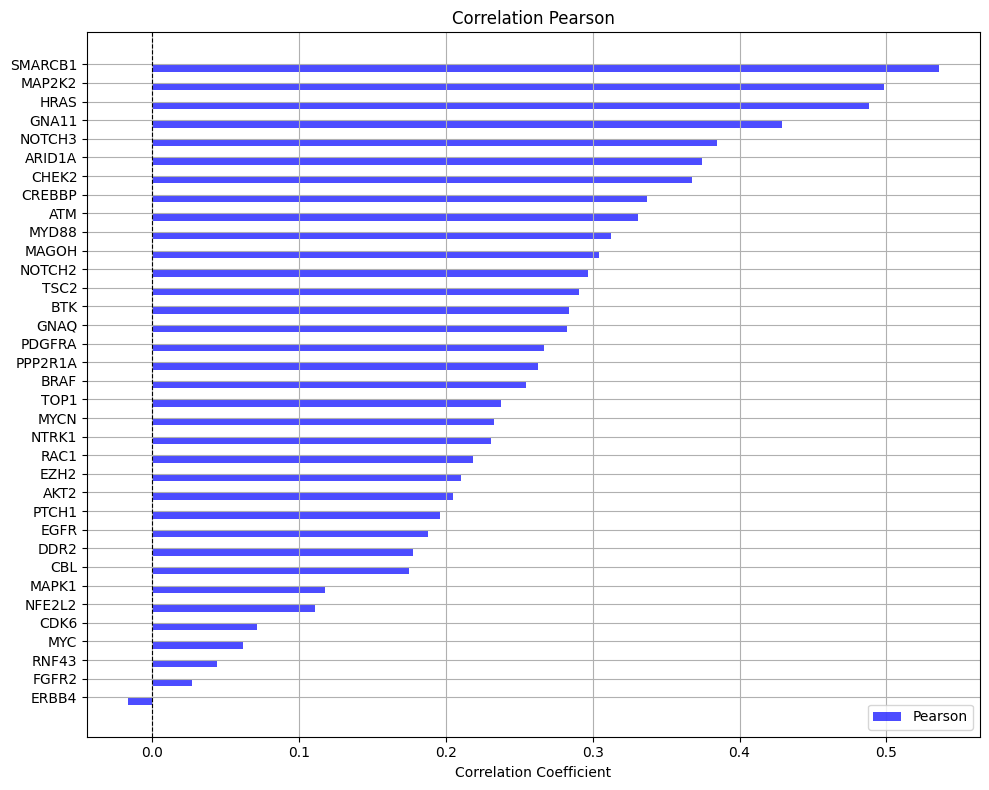

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the plot (example data, replace with actual values)
sort_idx = np.argsort(correls)  #[::-1]
genes = np.array(target_labels)[sort_idx]

# Plotting
y_pos = np.arange(len(genes))

plt.figure(figsize=(10, 8))
plt.barh(y_pos - 0.2,
         np.array(correls)[sort_idx],
         height=0.4,
         label='Pearson',
         color='blue',
         alpha=0.7)
# plt.barh(y_pos + 0.2, spearman, height=0.4, label='Spearman', color='orange', alpha=0.7)

plt.yticks(y_pos, gene_names.iloc[genes][0].values)
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Pearson")
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()


In [131]:
sort_idx

array([ 7, 19,  3, 29, 18, 27, 13, 22, 10,  5, 20,  4,  8, 15, 26, 14, 25,
       33, 24, 32, 23,  1, 17, 28, 31, 21, 34, 12, 30,  6, 11,  0,  2,  9,
       16])

In [128]:
import seaborn as sns

In [136]:
sns.regplot?

Signature:
sns.regplot(
    data=None,
    *,
    x=None,
    y=None,
    x_estimator=None,
    x_bins=None,
    x_ci='ci',
    scatter=True,
    fit_reg=True,
    ci=95,
    n_boot=1000,
    units=None,
    seed=None,
    order=1,
    logistic=False,
    lowess=False,
    robust=False,
    logx=False,
    x_partial=None,
    y_partial=None,
    truncate=True,
    dropna=True,
    x_jitter=None,
    y_jitter=None,
    label=None,
    color=None,
    marker='o',
    scatter_kws=None,
    line_kws=None,
    ax=None,
)
Docstring:
Plot data and a linear regression model fit.

There are a number of mutually exclusive options for estimating the
regression model. See the :ref:`tutorial <regression_tutorial>` for more
information.    

Parameters
----------
x, y: string, series, or vector array
    Input variables. If strings, these should correspond with column names
    in ``data``. When pandas objects are used, axes will be labeled with
    the series name.
data : DataFrame
    Tidy ("long-

In [147]:
np.corrcoef(y_test.values[:, sort_idx[-1]].astype(float), y_pred[:,sort_idx[-1]])[0,1]

0.5361396119343604

Text(0.5, 1.0, 'Pearson: 0.536')

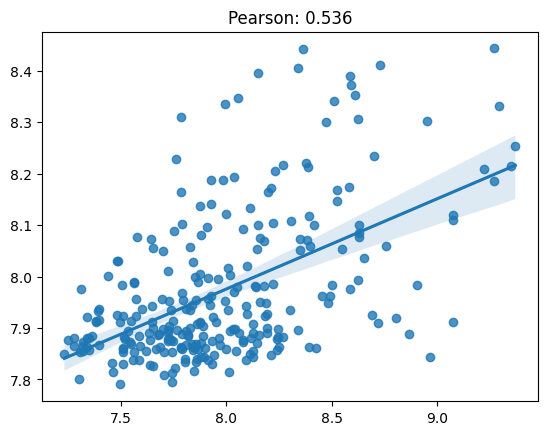

In [152]:
pearson = np.corrcoef(y_test.values[:, sort_idx[-1]].astype(float), y_pred[:,sort_idx[-1]])[0,1]
sns.regplot(x=y_test.values[:, sort_idx[-1]].astype(float), y=y_pred[:,sort_idx[-1]], )
plt.title(f"Pearson: {pearson:.3f}")

Text(0.5, 1.0, 'Pearson: 0.498')

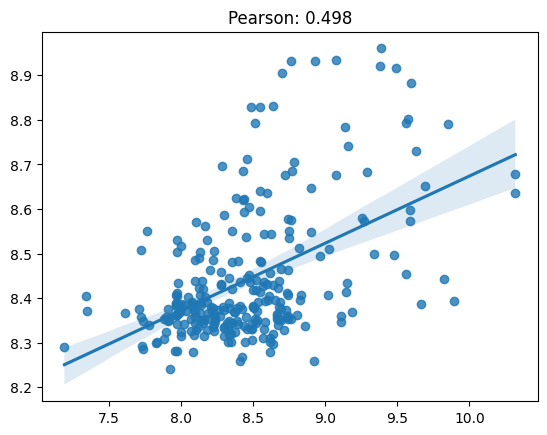

In [153]:
pearson = np.corrcoef(y_test.values[:, sort_idx[-2]].astype(float), y_pred[:,sort_idx[-2]])[0,1]
sns.regplot(x=y_test.values[:, sort_idx[-2]].astype(float), y=y_pred[:,sort_idx[-2]], )
plt.title(f"Pearson: {pearson:.3f}")

Text(0.5, 1.0, 'Pearson: 0.488')

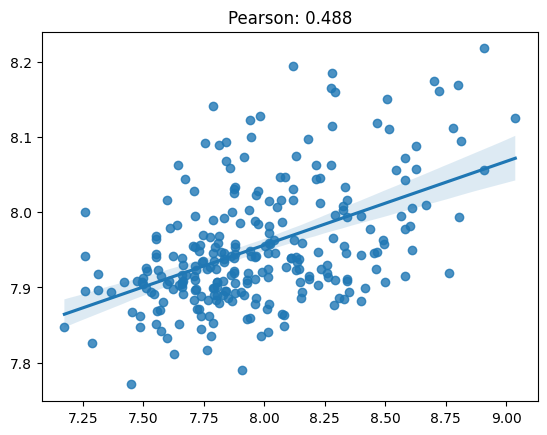

In [154]:
pearson = np.corrcoef(y_test.values[:, sort_idx[-3]].astype(float), y_pred[:,sort_idx[-3]])[0,1]
sns.regplot(x=y_test.values[:, sort_idx[-3]].astype(float), y=y_pred[:,sort_idx[-3]], )
plt.title(f"Pearson: {pearson:.3f}")